In [2]:
import numpy as np
import json
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import multiprocessing
import networkx as nx
import random
import time

Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
def WriteToJSON(in_data, in_file_path):
    json_str = json.dumps(in_data)
    json_bytes = json_str.encode('utf-8')
    with open(in_file_path, 'wb') as fout:
        fout.write(json_bytes)
        
def ReadFromJSON(in_file_path):
    with open(in_file_path, 'rb') as fin:
        json_bytes = fin.read()
    json_str = json_bytes.decode('utf-8')
    data = json.loads(json_str)
    return data

"""Use the following function to read the neighbors json file"""
def ReadNeighborsAsIntegers(in_file_path):
    # read data as string
    data = ReadFromJSON(in_file_path)
    # convert all node ids to integers
    data = {int(k):[int(e) for e in v] for k,v in data.items()}
    return data

def get_in_neighbors_from_nx(in_graph):
    inNeighbors = {}
    for src, tgt in nx.edges(in_graph):
        if tgt in inNeighbors:
            inNeighbors[tgt].append(src)
        else:
            inNeighbors[tgt] = [src]
    return inNeighbors

## Generalized Model Definition

In [3]:
""" Named Constants used for addressing the indexes of model Node States """
NS_STATE = 0
NS_NEXT_STATE = 1
NS_WAS_ACTIVATED_PREV_STEP = 2
NS_INIT_STATE = 3
NS_INIT_WAS_ACTIVATED_PREV_STEP = 4

""" Reads the network from the given inNeighbors.json file """
def read_network(in_network_file):
    node_in_neighbors = ReadNeighborsAsIntegers(in_network_file)
    name_parts = os.path.basename(in_network_file).split('_')
    #print(name_parts)
    network_index = int(name_parts[1])
    network_size = int(name_parts[2][1:])
    beta = float((name_parts[3][1:]).replace('o','.'))
    din = float((name_parts[4][3:]).replace('o','.'))
    dout = float((name_parts[5][4:]).replace('o','.'))
    net = {"id" : network_index,
           "size": network_size,
           "beta": beta,
           "delta_in": din,
           "delta_out": dout,
           "in_neighbors": node_in_neighbors,
           }
    return net

""" Given a network data read from a file, creates and initializes a usable simulation instance for DOI experiments
    Susceptible == False
    Infected == True
    Returns created simulation dictionary object
"""
def setup_simulation_instance(in_network, in_init_fract_infection):
    network_size = in_network["size"]
    NodeState = np.zeros((5, network_size), dtype=bool)
    init_infected_nodeidx_list = np.random.choice(network_size, round(in_init_fract_infection * network_size), replace=False)
    NodeState[NS_INIT_STATE, init_infected_nodeidx_list] = True
    NodeState[NS_INIT_WAS_ACTIVATED_PREV_STEP, init_infected_nodeidx_list] = True
    #print(f"Initial infected nodes: {len(init_infected_nodeidx_list)}")
    sim = {"NodeState": NodeState, "InitInfects":init_infected_nodeidx_list}
    return sim
    
""" Copies initial states to the current states of nodes """
def initialize(in_network, inout_simulation):
    NodeState = inout_simulation["NodeState"]
    NodeState[NS_STATE] = NodeState[NS_INIT_STATE]
    NodeState[NS_NEXT_STATE] = NodeState[NS_INIT_STATE]
    NodeState[NS_WAS_ACTIVATED_PREV_STEP] = NodeState[NS_INIT_WAS_ACTIVATED_PREV_STEP]
    
   
""" Runs the simulation """
def run(inout_simulation, in_network, in_model, in_max_steps=10000):
    
    infection_at_step = []
    
    network_size = in_network["size"]
    NodeState = inout_simulation["NodeState"]
    
    in_model.setup(in_network, inout_simulation)
    
    for step in (range(in_max_steps)):
        
        infection_at_this_step = 0

        # Process F > G for all Susceptible nodes and mark for state change
        for node_idx in range(network_size):
            if not NodeState[NS_STATE, node_idx]:
                # execute following for all Susceptible
                F = in_model.F(node_idx, NodeState, in_network["in_neighbors"], inout_simulation)
                G = in_model.G()
                if G <= F:
                    NodeState[NS_NEXT_STATE, node_idx] = True
        
        # Reset excitement of all nodes back
        NodeState[NS_WAS_ACTIVATED_PREV_STEP] = False
        
        for node_idx in range(network_size):
            if not NodeState[NS_STATE, node_idx] and NodeState[NS_NEXT_STATE, node_idx]:
                NodeState[NS_WAS_ACTIVATED_PREV_STEP, node_idx] = True
                infection_at_this_step += 1
        
        # Copy the next state onto state
        NodeState[NS_STATE] = NodeState[NS_NEXT_STATE]

        infection_at_step.append( infection_at_this_step )
        
        # stop if no change for 1000 steps
        if step > 1000 and step % 1000 == 1 and np.sum(infection_at_step[-1000:]) == 0:
            #print("No change for 1000 steps")
            break

    inout_simulation["InfectionAtStep"] = infection_at_step
    inout_simulation["StopAt"] = step
    return

### Instances of the generalized Model

In [4]:
class LATM:
    def __init__(self, in_threshold):
        self.threshold = in_threshold
        
    def setup(self, in_network, inout_simulation):
        pass
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        infected_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_STATE, neighbor_idx]]
        return len(infected_neighborhood)

    def G(self):
        return self.threshold


In [5]:
class LFTM:
    def __init__(self, in_threshold):
        self.threshold = in_threshold
        
    def setup(self, in_network, inout_simulation):
        pass
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        infected_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_STATE, neighbor_idx]]
        return len(infected_neighborhood) / len(neighborhood) if len(neighborhood) > 0 else 0

    def G(self):
        return self.threshold


In [6]:
class ICM:
    def __init__(self, in_imitation):
        self.imitation = in_imitation
        
    def setup(self, in_network, inout_simulation):
        pass
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        active_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_WAS_ACTIVATED_PREV_STEP, neighbor_idx]]
        return 1.0 - ((1.0 - self.imitation) ** len(active_neighborhood))

    def G(self):
        return random.random()


## Network Generators

In [7]:
def generate_network(in_network_type, in_network_param):
    net_size = 1000
    if in_network_type == "SMALLWORLD":
        G = nx.connected_watts_strogatz_graph(n=net_size, k=5, p=in_network_param)
        c = nx.clustering(G)
        cc_dist = np.array([c[node] for node in c])
        cc_mean = cc_dist.mean()
        cc_std = cc_dist.std()
        net = {"size": net_size,
               "param_name": "p",
               "param": in_network_param,
               "type": in_network_type,
               "in_neighbors": nx.to_dict_of_lists(G),
               "cluscoefdist": c,
               "clscoef_mean": cc_mean, 
               "clscoef_std": cc_std }
        return net 
    elif in_network_type == "RANDOM":
        G = nx.erdos_renyi_graph(n=net_size, p=in_network_param)
        c = nx.clustering(G)
        cc_dist = np.array([c[node] for node in c])
        cc_mean = cc_dist.mean()
        cc_std = cc_dist.std()
        net = {"size": net_size,
               "param_name": "p",
               "param": in_network_param,
               "type": in_network_type,
               "in_neighbors": nx.to_dict_of_lists(G),
               "cluscoefdist": c,
               "clscoef_mean": cc_mean, 
               "clscoef_std": cc_std }
        return net
    elif in_network_type == "BARABASI":
        G = nx.barabasi_albert_graph(n=net_size, m=in_network_param)
        c = nx.clustering(G)
        cc_dist = np.array([c[node] for node in c])
        cc_mean = cc_dist.mean()
        cc_std = cc_dist.std()
        net = {"size": net_size,
               "param_name": "m",
               "param": in_network_param,
               "type": in_network_type,
               "in_neighbors": nx.to_dict_of_lists(G),
               "cluscoefdist": c,
               "clscoef_mean": cc_mean, 
               "clscoef_std": cc_std }
        return net    

In [8]:
def run_dynamic_trial(in_network, in_model, in_initial_frac_infection):
    # setup 
    sim = setup_simulation_instance(in_network, in_initial_frac_infection)

    initialize(in_network, sim)
    #print(sim['NodeState'])

    run(sim, in_network, in_model)

    #print("Stopped at : " + str(sim["StopAt"]))
    #print(sim['NodeState'])
    
    final_infected_fraction = (sim['NodeState'][NS_STATE].sum() - len(sim["InitInfects"])) / in_network['size']
    net_percent_value = np.sum([v * (0.9 ** t) for t,v in enumerate(sim["InfectionAtStep"])])
    return net_percent_value, final_infected_fraction

In [9]:
def run_model(in_network, in_model_name, in_model_param, in_initial_frac_infection):
    np.random.seed() # <-- multiprocessing with different seeds
    if "LATM" == in_model_name:
        return run_dynamic_trial(in_network, LATM(in_model_param), in_initial_frac_infection)
    if "LFTM" == in_model_name:
        return run_dynamic_trial(in_network, LFTM(in_model_param), in_initial_frac_infection)
    if "ICM" == in_model_name:
        return run_dynamic_trial(in_network, ICM(in_model_param), in_initial_frac_infection)

In [10]:
model_param_range = {"ICM": np.arange(0.05, 1.0, 0.05), "LFTM": np.arange(0.05, 1.0, 0.05), "LATM": np.arange(1, 10, 1)}
model_param_range

{'ICM': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 'LFTM': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 'LATM': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [11]:
def data_for_network(in_network_model, in_net_param):
    net = generate_network(in_network_model, in_net_param)
    data = []
    print(f"Starting.. {in_network_model} ({in_net_param})")
    for MODEL_TO_ANALYZE in ["LATM", "LFTM", "ICM"]:
        for model_param in model_param_range[MODEL_TO_ANALYZE]:
            for init_inf in np.arange(0.025, 0.375, 0.025):
                npv, fif = run_model(net, MODEL_TO_ANALYZE, model_param, init_inf)
                data.append([net["type"], net["param"], net["clscoef_mean"], net["clscoef_std"], MODEL_TO_ANALYZE, model_param, init_inf, npv, fif])
    return pd.DataFrame(data, columns=["NetType","NetParam","CC_mean", "CC_std","Model","ModelParam","InitInf", "NPV", "FinalInf"])

In [12]:
net_params_sw = [["SMALLWORLD", net_param] for net_param in np.arange(0.1, 0.5, 0.05) for replicas in range(30)]
net_params_r = [["RANDOM", net_param] for net_param in np.arange(0.1, 0.5, 0.05) for replicas in range(30)]
net_params_ba = [["BARABASI", net_param] for net_param in np.arange(4, 8, 1) for replicas in range(30)]
net_params = net_params_r + net_params_ba + net_params_sw
net_params

[['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.1],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.15000000000000002],
 ['RANDOM', 0.1500

In [ ]:
with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as P:
    results = P.starmap(data_for_network, net_params)
    
print("DONE")

Starting.. RANDOM (0.1)
Starting.. RANDOM (0.1)Starting.. RANDOM (0.1)

Starting.. RANDOM (0.1)
Starting.. RANDOM (0.1)
Starting.. RANDOM (0.1)
Starting.. RANDOM (0.1)Starting.. RANDOM (0.1)
Starting.. RANDOM (0.1)
Starting.. RANDOM (0.1)Starting.. RANDOM (0.1)Starting.. RANDOM (0.1)
Starting.. RANDOM (0.1)Starting.. RANDOM (0.1)
Starting.. RANDOM (0.1)




Starting.. RANDOM (0.15000000000000002)
Starting.. RANDOM (0.15000000000000002)
Starting.. RANDOM (0.15000000000000002)Starting.. RANDOM (0.15000000000000002)
Starting.. RANDOM (0.15000000000000002)

Starting.. RANDOM (0.15000000000000002)
Starting.. RANDOM (0.15000000000000002)
Starting.. RANDOM (0.15000000000000002)Starting.. RANDOM (0.15000000000000002)
Starting.. RANDOM (0.15000000000000002)

Starting.. RANDOM (0.15000000000000002)Starting.. RANDOM (0.15000000000000002)
Starting.. RANDOM (0.15000000000000002)

Starting.. RANDOM (0.15000000000000002)
Starting.. RANDOM (0.15000000000000002)
Starting.. RANDOM (0.20000000000000004)


In [ ]:
df = pd.concat(results, ignore_index=True)

df.to_csv("./cc_outputs/CCDiffusion_n1000.csv", index=False)

In [17]:
df

NetType  NetParam   CC_mean    CC_std Model  ModelParam  InitInf   
0           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.025  \
1           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.050   
2           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.075   
3           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.100   
4           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.125   
...            ...       ...       ...       ...   ...         ...      ...   
394795  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.250   
394796  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.275   
394797  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.300   
394798  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.325   
394799  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.350   

            NPV  FinalInf  
0       967.000     0.975  
1       949.300     0.950  
2       925.000     0.925  
3       900.000     0.900  
4       875.000     0.875  
...         ...       ...  
394795  720.570     0.750  
394796  699.339     0.725  
394797  677.560     0.700  
394798  656.980     0.675  
394799  635.750     0.650  

[394800 rows x 9 columns]

In [19]:
df["Model_and_Param"] = df.apply(lambda row: "{}_p{}".format(row["Model"],row["ModelParam"]), axis=1)
df

NetType  NetParam   CC_mean    CC_std Model  ModelParam  InitInf   
0           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.025  \
1           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.050   
2           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.075   
3           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.100   
4           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.125   
...            ...       ...       ...       ...   ...         ...      ...   
394795  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.250   
394796  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.275   
394797  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.300   
394798  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.325   
394799  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.350   

            NPV  FinalInf          Model_and_Param  
0       967.000     0.975                LATM_p1.0  
1       949.300     0.950                LATM_p1.0  
2       925.000     0.925                LATM_p1.0  
3       900.000     0.900                LATM_p1.0  
4       875.000     0.875                LATM_p1.0  
...         ...       ...                      ...  
394795  720.570     0.750  ICM_p0.9500000000000001  
394796  699.339     0.725  ICM_p0.9500000000000001  
394797  677.560     0.700  ICM_p0.9500000000000001  
394798  656.980     0.675  ICM_p0.9500000000000001  
394799  635.750     0.650  ICM_p0.9500000000000001  

[394800 rows x 10 columns]

In [ ]:
df.to_csv("./cc_outputs/CCDiffusion_n1000_added_columns.csv", index=False)

In [ ]:
df.NPV

In [ ]:
df["CC_std"] / df["CC_mean"]

## TESTS

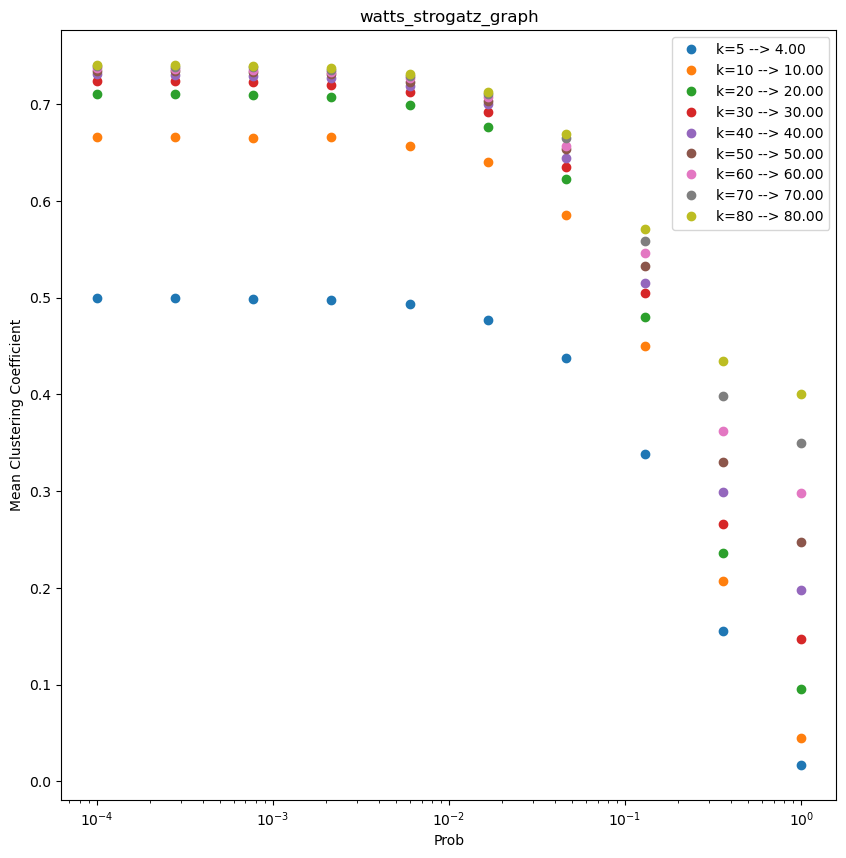

In [4]:
NumNodes = 200
NumReplicas = 10

plt.figure(figsize=(10,10))
           
for AvgDegree in np.array([5, 10, 20, 30, 40, 50, 60, 70, 80]):
    data = []

    def calCC(p):
        cvals = []
        current_avg_degree = []
        for i in range(NumReplicas):
            g = nx.watts_strogatz_graph(NumNodes, AvgDegree, p)
            c = nx.clustering(g)
            cc = np.array([c[node] for node in c]).mean()
            cvals.append(cc)
            current_avg_degree.append(np.array(list(dict(g.degree()).values())).mean())
        cvals = np.array(cvals)
        current_avg_degree = np.array(current_avg_degree)
        row = [p, cvals.mean(), cvals.std(), current_avg_degree.mean()]
        return row

    with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as P:
        data = P.map(calCC, np.geomspace(0.0001, 1.0, 10, True))

    df = pd.DataFrame(data, columns=["Prob", "AvgCC", "StdCC", "FinalAvgDeg"])
    meanFAD = df["FinalAvgDeg"].mean()
    df.set_index("Prob")["AvgCC"].plot(linestyle='None', marker='o', label="k={} --> {:4.02f}".format(AvgDegree, meanFAD))
    
plt.xscale('log')
plt.title(f"watts_strogatz_graph")
plt.ylabel("Mean Clustering Coefficient")
plt.legend()
plt.show()

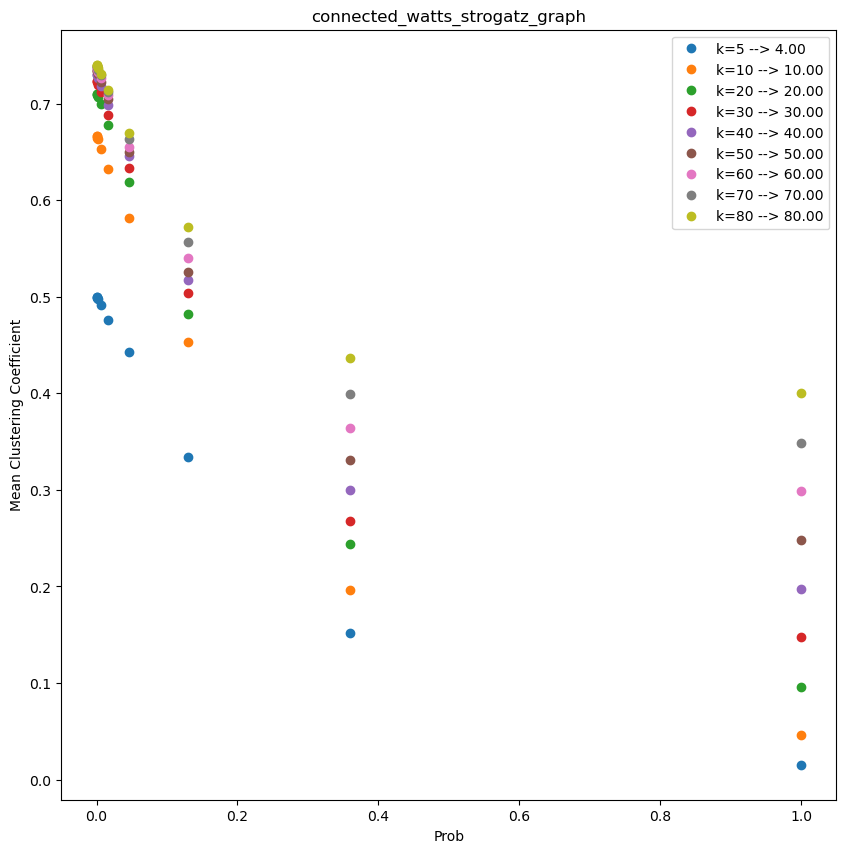

In [5]:
NumNodes = 200
NumReplicas = 10

plt.figure(figsize=(10,10))
           
for AvgDegree in np.array([5, 10, 20, 30, 40, 50, 60, 70, 80]):
    data = []

    def calCC(p):
        cvals = []
        current_avg_degree = []
        for i in range(NumReplicas):
            g = nx.connected_watts_strogatz_graph(NumNodes, AvgDegree, p)
            c = nx.clustering(g)
            cc = np.array([c[node] for node in c]).mean()
            cvals.append(cc)
            current_avg_degree.append(np.array(list(dict(g.degree()).values())).mean())
        cvals = np.array(cvals)
        current_avg_degree = np.array(current_avg_degree)
        row = [p, cvals.mean(), cvals.std(), current_avg_degree.mean()]
        return row

    with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as P:
        data = P.map(calCC, np.geomspace(0.0001, 1.0, 10, True))

    df = pd.DataFrame(data, columns=["Prob", "AvgCC", "StdCC", "FinalAvgDeg"])
    meanFAD = df["FinalAvgDeg"].mean()
    df.set_index("Prob")["AvgCC"].plot(linestyle='None', marker='o', label="k={} --> {:4.02f}".format(AvgDegree, meanFAD))
    
#plt.xscale('log')
plt.title(f"connected_watts_strogatz_graph")
plt.ylabel("Mean Clustering Coefficient")
plt.legend()
plt.show()

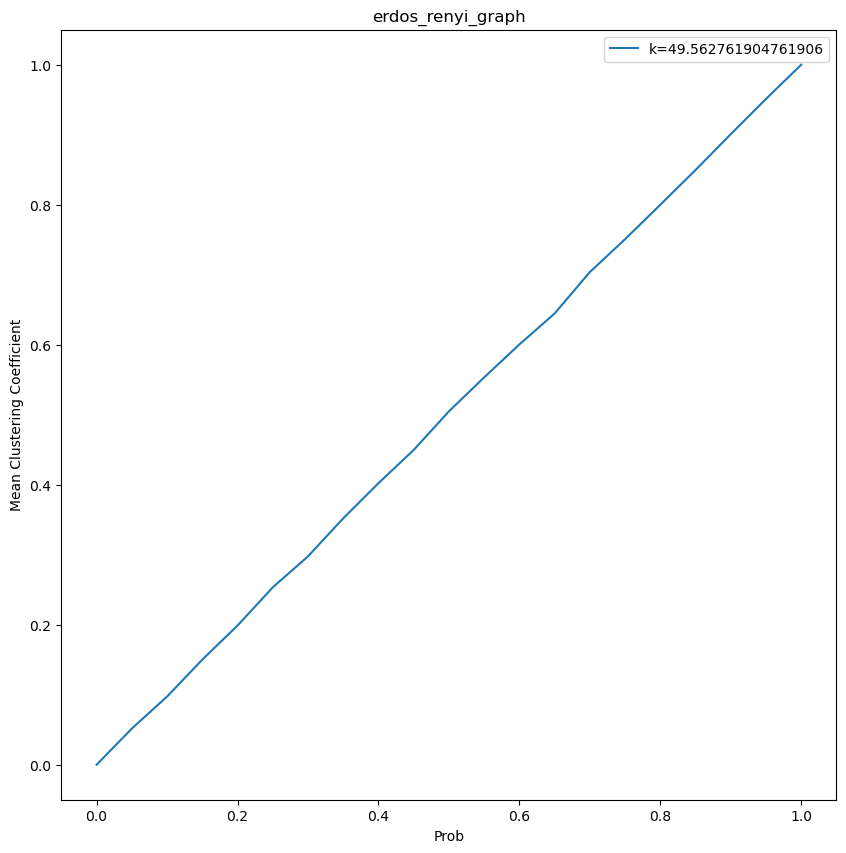

In [6]:
NumNodes = 100
NumReplicas = 10

plt.figure(figsize=(10,10))
           
data = []

def calCC(p):
    cvals = []
    current_avg_degree = []
    for i in range(NumReplicas):
        g = nx.erdos_renyi_graph(NumNodes, p)
        c = nx.clustering(g)
        cc = np.array([c[node] for node in c]).mean()
        cvals.append(cc)
        current_avg_degree.append(np.array(list(dict(g.degree()).values())).mean())
    cvals = np.array(cvals)
    current_avg_degree = np.array(current_avg_degree)
    row = [p, cvals.mean(), cvals.std(), current_avg_degree.mean()]
    return row

with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as P:
    data = P.map(calCC,np.arange(0, 1.05, 0.05))

df = pd.DataFrame(data, columns=["Prob", "AvgCC", "StdCC", "FinalAvgDeg"])
meanFAD = df["FinalAvgDeg"].mean()
df.set_index("Prob")["AvgCC"].plot(label=f"k={meanFAD}")
    
plt.title(f"erdos_renyi_graph")
plt.ylabel("Mean Clustering Coefficient")
plt.legend()
plt.show()

<Figure size 1000x1000 with 0 Axes>

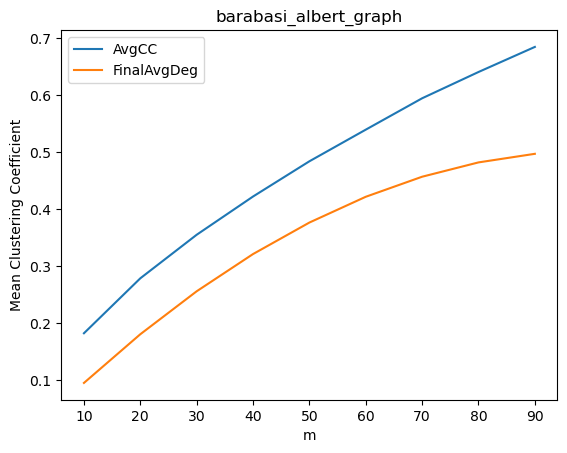

In [7]:
NumNodes = 200
NumReplicas = 10

plt.figure(figsize=(10,10))
           
def calCC(m):
    cvals = []
    current_avg_degree = []
    for i in range(NumReplicas):
        g = nx.barabasi_albert_graph(NumNodes, m)
        c = nx.clustering(g)
        cc = np.array([c[node] for node in c]).mean()
        cvals.append(cc)
        current_avg_degree.append(np.array(list(dict(g.degree()).values())).mean())
    cvals = np.array(cvals)
    current_avg_degree = np.array(current_avg_degree) / 199
    row = [m, cvals.mean(), cvals.std(), current_avg_degree.mean()]
    return row

with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as P:
    data = P.map(calCC, np.array([10, 20, 30, 40, 50, 60, 70, 80, 90]))

df = pd.DataFrame(data, columns=["m", "AvgCC", "StdCC", "FinalAvgDeg"])
meanFAD = df["FinalAvgDeg"].mean()
df.set_index("m")[["AvgCC", "FinalAvgDeg"]].plot(label=f"k={meanFAD}")
    
plt.title(f"barabasi_albert_graph")
plt.ylabel("Mean Clustering Coefficient")
plt.legend()
plt.show()

0.42666666666666664 0.30397368307141326


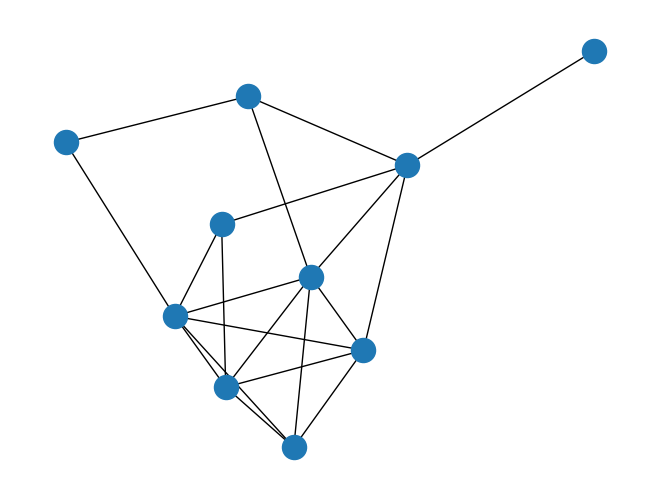

In [8]:
g = nx.erdos_renyi_graph(10, 0.5)
nx.draw(g)
c = nx.clustering(g)
ccdist = np.array([c[node] for node in c])
cc = ccdist.mean()
print(cc, ccdist.std())

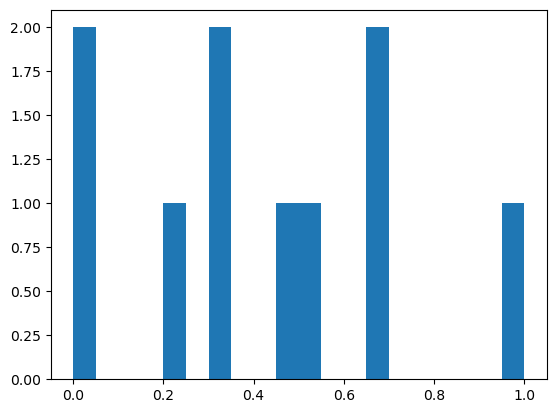

In [9]:
plt.hist(ccdist, bins=20)
plt.show()

In [10]:
def change_clustering(in_graph, in_target_cc_mean, in_max_iters=1000, in_tolerence = 0.01):
    c = nx.clustering(in_graph)
    cc = np.array([c[node] for node in c]).mean()
    neighbors = nx.to_dict_of_lists(in_graph)
    
    iters = 0
    while(abs(in_target_cc_mean - cc) > in_tolerence and iters < in_max_iters):
        iters += 1
        print(iters)
        if in_target_cc_mean < cc:
            # randomly pick an edge and rewire
            picked_node = np.random.choice([n for n in c if c[n] > 0])
            print(in_target_cc_mean, " Decrease cc of : ", picked_node, " --> ", c[picked_node])
            nbrset = set(neighbors[picked_node])
            # remove an edge between neighbors
            for nbr in nbrset:
                itrsc = nbrset.intersection(neighbors[nbr])
                if len(itrsc) > 0:
                    in_graph.remove_edge(nbr, list(itrsc)[0])
                    break
        elif in_target_cc_mean > cc:
            # randomly pick an edge and rewire
            picked_node = np.random.choice([n for n in c if c[n] < 1])
            print(in_target_cc_mean, " Increase cc of : ", picked_node, " --> ", c[picked_node])
            nbrset = set(neighbors[picked_node])
            # add an edge between neighbors
            for nbr in nbrset:
                potential_others = nbrset.difference(neighbors[nbr] + [nbr])
                in_graph.add_edge(nbr, list(potential_others)[0])
                break
        c = nx.clustering(in_graph)
        cc = np.array([c[node] for node in c]).mean()
        neighbors = nx.to_dict_of_lists(in_graph)

In [27]:
change_clustering(g, 0.78)

0.7728571428571429 0.2743167145179921


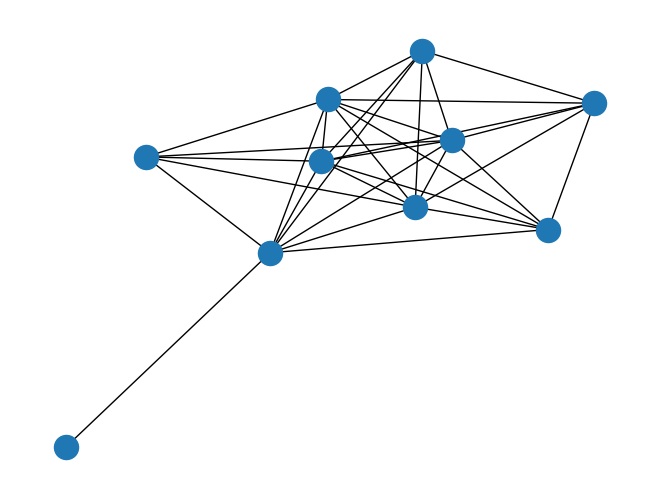

In [28]:
nx.draw(g)
c = nx.clustering(g)
ccdist = np.array([c[node] for node in c])
cc = ccdist.mean()
print(cc, ccdist.std())

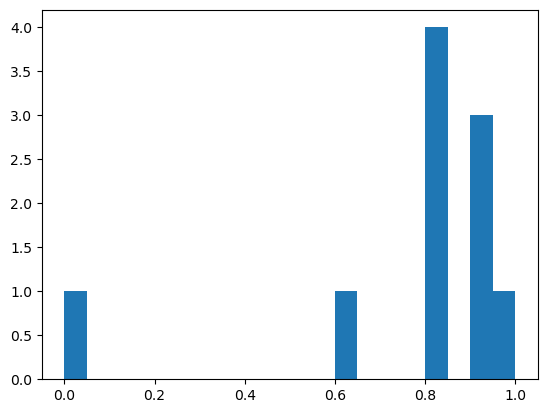

In [29]:
plt.hist(ccdist, bins=20)
plt.show()

In [ ]:
g = nx.erdos_renyi_graph(10, 0.5)
nx.draw(g)
c = nx.clustering(g)
ccdist = np.array([c[node] for node in c])
cc = ccdist.mean()
print(cc, ccdist.std())

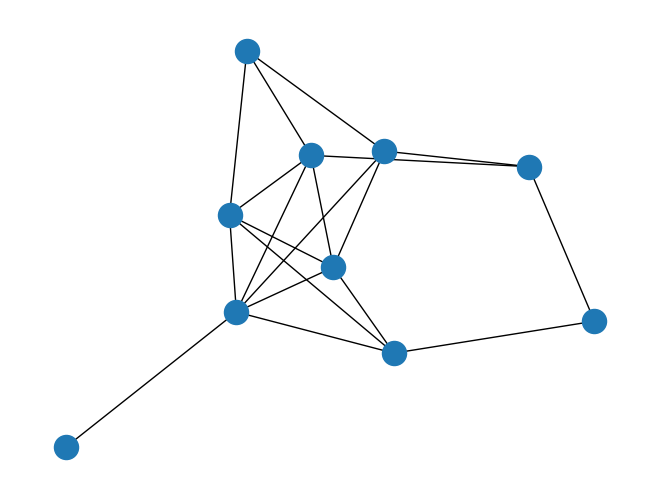

In [116]:
nx.draw(g)

In [118]:
neighbors

{0: [2, 5, 6, 8],
 1: [2, 3, 4, 6, 5],
 2: [0, 1, 4, 3, 5],
 3: [1, 5, 6, 8, 2],
 4: [1, 9, 2, 5],
 5: [0, 3, 7, 4, 1, 2],
 6: [0, 1, 3],
 7: [5],
 8: [3, 9, 0],
 9: [4, 8]}

In [ ]:
df

In [83]:
df = pd.read_csv("./cc_outputs/CCDiffusion_n1000_added_columns.csv")
df

NetType  NetParam   CC_mean    CC_std Model  ModelParam  InitInf   
0           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.025  \
1           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.050   
2           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.075   
3           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.100   
4           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.125   
...            ...       ...       ...       ...   ...         ...      ...   
394795  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.250   
394796  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.275   
394797  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.300   
394798  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.325   
394799  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.350   

            NPV  FinalInf          Model_and_Param  
0       967.000     0.975                LATM_p1.0  
1       949.300     0.950                LATM_p1.0  
2       925.000     0.925                LATM_p1.0  
3       900.000     0.900                LATM_p1.0  
4       875.000     0.875                LATM_p1.0  
...         ...       ...                      ...  
394795  720.570     0.750  ICM_p0.9500000000000001  
394796  699.339     0.725  ICM_p0.9500000000000001  
394797  677.560     0.700  ICM_p0.9500000000000001  
394798  656.980     0.675  ICM_p0.9500000000000001  
394799  635.750     0.650  ICM_p0.9500000000000001  

[394800 rows x 10 columns]

In [94]:
df["ModelParam01"] = df[["Model","ModelParam"]].apply(lambda row: (row["ModelParam"] - 1.0)/9.0 if row["Model"] == "LATM" else row["ModelParam"], axis=1)
df

NetType  NetParam   CC_mean    CC_std Model  ModelParam  InitInf   
0           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.025  \
1           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.050   
2           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.075   
3           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.100   
4           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.125   
...            ...       ...       ...       ...   ...         ...      ...   
394795  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.250   
394796  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.275   
394797  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.300   
394798  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.325   
394799  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.350   

            NPV  FinalInf          Model_and_Param  ModelParam01  
0       967.000     0.975                LATM_p1.0          0.00  
1       949.300     0.950                LATM_p1.0          0.00  
2       925.000     0.925                LATM_p1.0          0.00  
3       900.000     0.900                LATM_p1.0          0.00  
4       875.000     0.875                LATM_p1.0          0.00  
...         ...       ...                      ...           ...  
394795  720.570     0.750  ICM_p0.9500000000000001          0.95  
394796  699.339     0.725  ICM_p0.9500000000000001          0.95  
394797  677.560     0.700  ICM_p0.9500000000000001          0.95  
394798  656.980     0.675  ICM_p0.9500000000000001          0.95  
394799  635.750     0.650  ICM_p0.9500000000000001          0.95  

[394800 rows x 11 columns]

In [100]:
df[df["NetType"] == "BARABASI"]["NetParam"].unique()

array([4., 5., 6., 7.])

In [102]:
df["NetParam01"] = df[["NetType","NetParam"]].apply(lambda row: (row["NetParam"] - 4.0)/7.0 if row["NetType"] == "BARABASI" else row["NetParam"], axis=1)
df

NetType  NetParam   CC_mean    CC_std Model  ModelParam  InitInf   
0           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.025  \
1           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.050   
2           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.075   
3           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.100   
4           RANDOM      0.10  0.099138  0.004249  LATM        1.00    0.125   
...            ...       ...       ...       ...   ...         ...      ...   
394795  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.250   
394796  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.275   
394797  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.300   
394798  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.325   
394799  SMALLWORLD      0.45  0.088040  0.157961   ICM        0.95    0.350   

            NPV  FinalInf          Model_and_Param  ModelParam01  NetParam01  
0       967.000     0.975                LATM_p1.0          0.00        0.10  
1       949.300     0.950                LATM_p1.0          0.00        0.10  
2       925.000     0.925                LATM_p1.0          0.00        0.10  
3       900.000     0.900                LATM_p1.0          0.00        0.10  
4       875.000     0.875                LATM_p1.0          0.00        0.10  
...         ...       ...                      ...           ...         ...  
394795  720.570     0.750  ICM_p0.9500000000000001          0.95        0.45  
394796  699.339     0.725  ICM_p0.9500000000000001          0.95        0.45  
394797  677.560     0.700  ICM_p0.9500000000000001          0.95        0.45  
394798  656.980     0.675  ICM_p0.9500000000000001          0.95        0.45  
394799  635.750     0.650  ICM_p0.9500000000000001          0.95        0.45  

[394800 rows x 12 columns]

In [103]:
df.to_csv("./cc_outputs/CCDiffusion_n1000_params01.csv", index=False)

Model
ICM     [[Axes(0.125,0.11;0.775x0.77)]]
LATM    [[Axes(0.125,0.11;0.775x0.77)]]
LFTM    [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

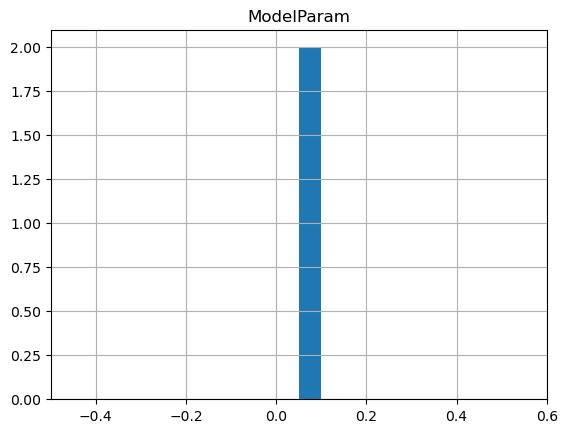

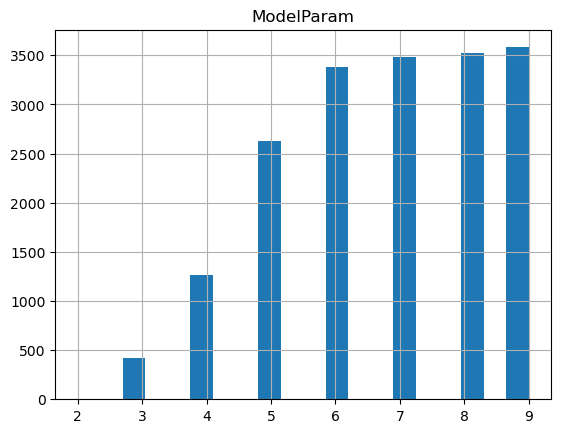

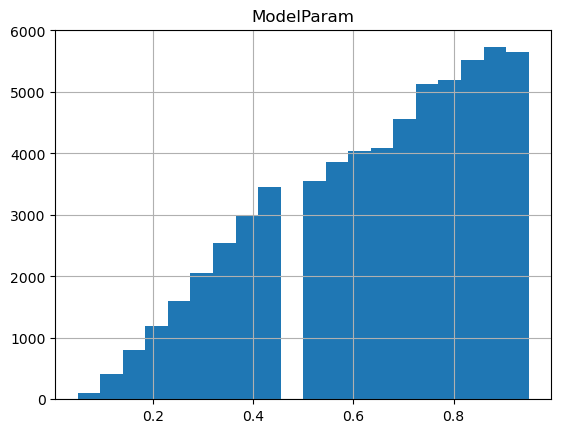

In [23]:
df[(df["NPV"] == 0)][["Model","ModelParam"]].groupby("Model").hist(bins=20)

<Axes: >

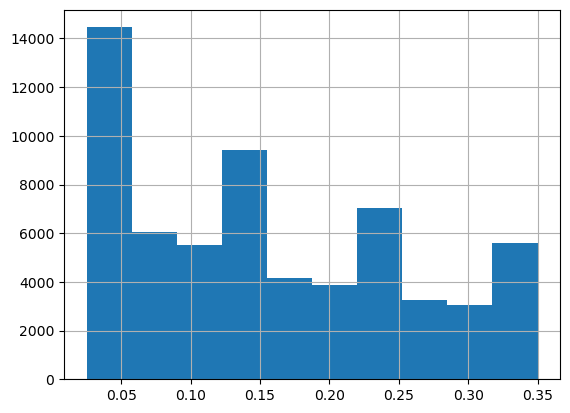

In [24]:
df[(df["NPV"] == 0) & (df["Model"] == "LFTM")]["InitInf"].hist()

In [136]:
df[(df["NPV"] == 0) & (df["Model"] == "LATM")]

NetType  NetParam   CC_mean    CC_std Model  ModelParam  InitInf   
28          RANDOM      0.10  0.115653  0.045008  LATM         3.0    0.025  \
42          RANDOM      0.10  0.115653  0.045008  LATM         4.0    0.025   
43          RANDOM      0.10  0.115653  0.045008  LATM         4.0    0.050   
56          RANDOM      0.10  0.115653  0.045008  LATM         5.0    0.025   
57          RANDOM      0.10  0.115653  0.045008  LATM         5.0    0.050   
...            ...       ...       ...       ...   ...         ...      ...   
394263  SMALLWORLD      0.45  0.109095  0.177390  LATM         9.0    0.250   
394264  SMALLWORLD      0.45  0.109095  0.177390  LATM         9.0    0.275   
394265  SMALLWORLD      0.45  0.109095  0.177390  LATM         9.0    0.300   
394266  SMALLWORLD      0.45  0.109095  0.177390  LATM         9.0    0.325   
394267  SMALLWORLD      0.45  0.109095  0.177390  LATM         9.0    0.350   

        NPV  FinalInf  
28      0.0       0.0  
42      0.0       0.0  
43      0.0       0.0  
56      0.0       0.0  
57      0.0       0.0  
...     ...       ...  
394263  0.0       0.0  
394264  0.0       0.0  
394265  0.0       0.0  
394266  0.0       0.0  
394267  0.0       0.0  

[30046 rows x 9 columns]

In [70]:
df["CC_mean"].min(), df["CC_mean"].max()

(0.029410900116893, 0.4519536314354884)

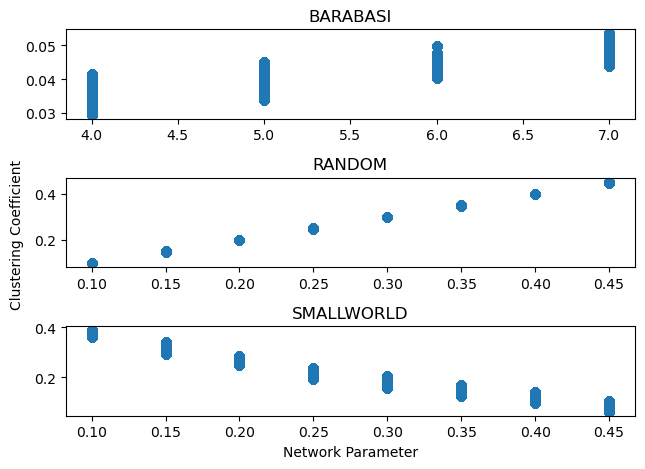

In [56]:
groups = df[["CC_mean","NetType","NetParam"]].groupby('NetType')

# Plot
fig, axs = plt.subplots(3, sharey=False)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
i = 0
for name, group in groups:
    axs[i].plot(group.NetParam, group.CC_mean, marker='o', linestyle='',label=name)
    axs[i].set_title(name)
    i += 1
ax.legend()
plt.xlabel("Network Parameter")
fig.text(0, 0.5, 'Clustering Coefficient', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

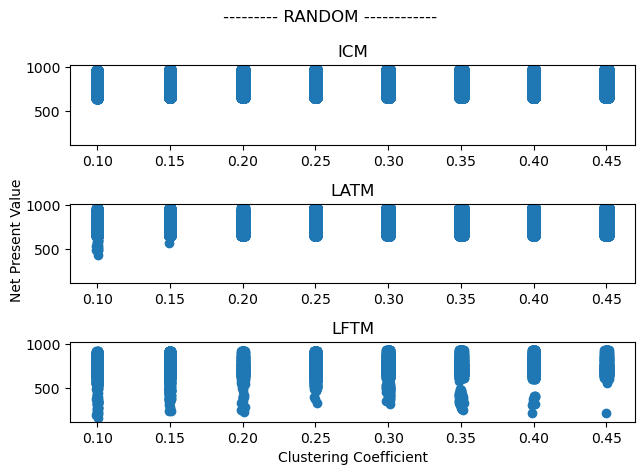

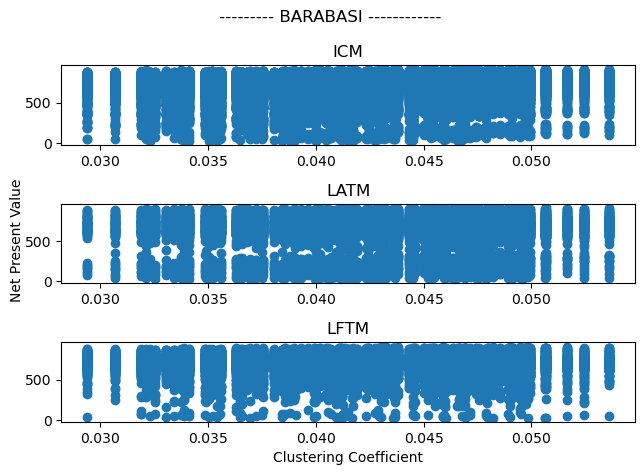

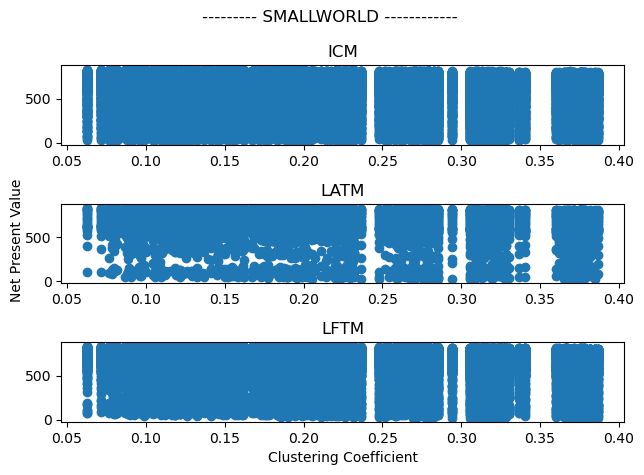

In [81]:
for nettype in df["NetType"].unique():
    groups = df[(df["FinalInf"] > df["InitInf"]) & (df["NetType"] == nettype)][["NPV","Model","CC_mean","InitInf"]].groupby('Model')

    # Plot
    fig, axs = plt.subplots(3, sharey=True)
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    i = 0
    for name, group in groups:
        axs[i].plot(group.CC_mean, group.NPV, marker='o', linestyle='',label=name)
        axs[i].set_title(name)
        i += 1
    ax.legend()
    plt.xlabel("Clustering Coefficient")
    fig.text(0, 0.5, 'Net Present Value', va='center', rotation='vertical')
    plt.suptitle(f"--------- {nettype} ------------")
    plt.tight_layout()
    plt.savefig(f"CCvsNPV_{nettype}.png")
    plt.show()